In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter
import numpy as np 
from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    
from svr import SVR
import torch 


Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/home/linuxbrew/.linuxbrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Using GPU!


# VGG 

In [2]:

import torch
from svr import SVR
import matplotlib.pyplot as plt 
 
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn',pretrained=True)

weights= [ w.detach() for w in model.parameters() if len(w.shape)>1 ]
# This definion of weights discards scaling induced by batchnorm 
# this does not really matter for our experiments 
svr = SVR(weights,method='svr',max_dim_svd=600)


Using cache found in /home/meller/.cache/torch/hub/pytorch_vision_v0.10.0
100%|███████████████████████████████████████████| 19/19 [01:42<00:00,  5.41s/it]


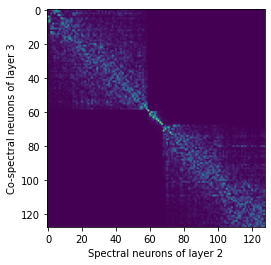

In [19]:
# Adjacency HOSVD

layer = 2
A = weights[layer]
B = weights[layer+1]

randNormA = torch.normal(torch.zeros(A.shape[0],A.shape[0]),1)
randRotA,_,_  = torch.svd(randNormA) 
randNormB = torch.normal(torch.zeros(A.shape[0],A.shape[0]),1)
randRotB,_,_  = torch.svd(randNormB) 


_,S1,V = torch.svd((B.transpose(0,1).flatten(start_dim=1).transpose(0,1))@randRotB) # oz,i
U,S2,_ =  torch.svd(randRotA@A.flatten(start_dim=1))
U,V = randRotA.T@U,(randRotB@V) 
#We use random rotations to eliminate any bias due to the canonical basis

adja = torch.abs(V.T@U)

plt.imshow(adja)
plt.xlabel('Spectral neurons of layer '+str(layer))
plt.ylabel('Co-spectral neurons of layer '+str(layer+1))
plt.show()


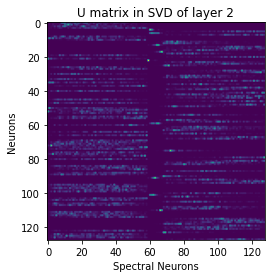

In [20]:
plt.imshow(torch.abs(U))
plt.xlabel('Spectral Neurons')
plt.ylabel('Neurons')
plt.title('U matrix in SVD of layer '+str(layer))
plt.show()

# Modeling baseline distribution of adjacency coefficients 

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3296.11it/s]


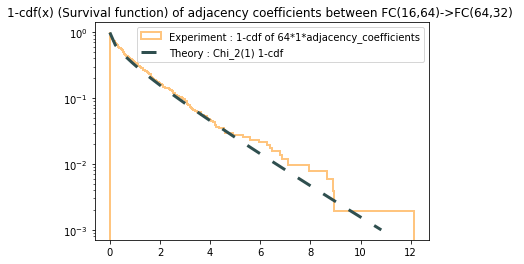

In [25]:
# Agreement chi2-svr en pratique 
from scipy.stats import chi2,norm
import numpy as np 

# Parameters for convolutional layer
""" 
c,z = 5,3*3
w1 = torch.randn(c,16,3,3)
w2 = torch.randn(32,c,3,3)
""" 
# Parameter for fully connected layer 

c,z = 64,1
w1 = torch.randn(c,16)
w2 = torch.randn(32,c)

conv_svr = SVR([w1,w2])
a = conv_svr.adjacency[0].flatten().numpy()
a_normalized = a*z*c


plt.hist(a_normalized,label="Experiment : 1-cdf of 64*1*adjacency_coefficients",
         alpha=0.5,lw=2,bins=500,density=True,cumulative=-1,histtype='step',color='darkorange')
plt.yscale('log')
x = np.linspace(chi2.ppf(0.01, z),chi2.ppf(0.999, z), 50)
plt.plot(x, 1-chi2.cdf(x, z),linestyle=(0, (5, 5)), lw=3, label='Theory : Chi_2(1) 1-cdf',color='darkslategrey')
plt.legend()
plt.title('1-cdf(x) (Survival function) of adjacency coefficients between FC(16,64)->FC(64,32) ')
plt.show()
